# __Table of Contents__
* [Introduction](#Introduction)
* Data
    * [Gathering Data](#Gathering-Data)
    * [Preparing Data](#Preparing-Data)
* Model
    * [Choosing and Training a Model](#Choosing-and-Training-a-Model)
    * [Hyperparameter Tuning](#Hyperparameter-Tuning)
* Making Predictions and Forecasts
    * [Test Data Predictions](#Test-Data-Predictions)
    * [Evaluation](#Evaluation)
* [Conclusion](#Conclusion)


<a id="Introduction"></a>
# **Introduction**
This investigation aims to train a deep learning model to predict the genre of a 30-second song snippet from its spectrogram, saved as a 432x288px .png file.

**Hypotheses:** 
* I believe that a standard Convolutional Neural Network regression model will yield the best results given its adeptness in this data format.
* However, given the highly variable and subjective nature of music genres, I belive that there is only so much a small-scale neural network like mine will be able to achieve in terms of accuracy in its predictions. I am aiming for above 80% testing accuracy as an ideal result.

## Installing Dependencies and Setting Up
Before I begin, the required modules need to be installed and imported on the virtual machine. These assist in a variety of tasks, ranging from data manipulation and exploration to training models.

I will also create a function to reset the random seed of the model to ensure consistent and reproduceable results throughout.

In [1]:
!pip install livelossplot

In [4]:
import random, os, glob # default python modules that let me randomise and manipulate files
import numpy as np # for data manipulation through arrays
import tensorflow as tf
from keras.models import Sequential # the model I will use
from keras.layers import Dropout, Dense, Conv2D, MaxPool2D, Flatten, Reshape, BatchNormalization, GlobalAveragePooling2D # layers I will incorporate
from keras.callbacks import EarlyStopping # for better training
from tensorflow.keras.applications import VGG19 # transfer learning model
from keras import backend
from livelossplot import PlotLossesKeras # to visualy display how my model improves as training progresses
import librosa # to demonstrate the creation of a mel spectrogram
from librosa.display import specshow
import matplotlib.pyplot as plt
import IPython.display as ipd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [3]:
def setRandom():
    seed = 0 # random seed value
    os.environ["PYTHONHASHSEED"] = str(seed) # if this is not set, a random value is used to seed the hashes of some objects
    random.seed(seed) # sets the base python and numpy random seeds
    np.random.seed(seed)
    tf.random.set_seed(seed) # sets the tensorflow random seed
    tf.compat.v1.set_random_seed(seed)

<a id="Gathering-Data"></a>
# __Gathering Data__
The dataset I have chosen is the **GTZAN dataset**, which is one of the most well-known music classification datasets available due to its use in the 2002 paper '*Musical genre classification of audio signals*' by G. Tzanetakis and P. Cook. It contains **100 audio files** recorded from CDs and other sources for each of the following genres:
* blues
* classical
* country
* disco
* hiphop
* jazz
* metal
* pop
* reggae
* and rock.

To fit a neural network to audio data, a common method is to convert the audio to a visual representation (spectrogram) before feeding the pixel values into an image classifier. Instead of a traditional Hertz-based spectrogram, a mel spectrogram is often preferred due to its ability to better represent human auditory perception. Its logarithmic scale approximates this much better than the linear scale of Hertz by emphasising the bands of pitch and volume that are more pronounced to human listeners.

<img src="https://www.sfu.ca/sonic-studio-webdav/handbook/Graphics/Mel.gif" width="300"/>

Luckily for me, the dataset has also provided me with a set of premade mel spectrograms generated from the provided audio files. This means I won't have to make my own mel spectrograms for each audio file.

Below is an example of how the spectrograms could have been made if i had to, as long as the accompanying '.wav' file that it was made from.

In [7]:
def wav_to_image(filePath):
    file, samplingRate = librosa.load(filePath)
    example, _ = librosa.effects.trim(file)
    hopLength = 512
    spectrogram = librosa.power_to_db(librosa.feature.melspectrogram(y = example, sr = samplingRate, n_fft = 2048, hop_length = hopLength, n_mels = 128, power = 4.0 ), ref = np.max)
    imgSize = (288, 432)
    fig, ax = plt.subplots(figsize=(imgSize[1] / 100, imgSize[0] / 100), dpi=100)
    ax.axis('off')
    librosa.display.specshow(spectrogram, sr = samplingRate, hop_length = hopLength, x_axis = "off", y_axis = "off")
    temp_img_path = 'temp_spectrogram.png'
    plt.savefig(temp_img_path, bbox_inches='tight', pad_inches=0)
    plt.close(fig)
    image = tf.image.decode_png(tf.io.read_file(temp_img_path), channels=3)
    image = tf.image.resize(image, imgSize)
    # Normalize the pixel values between 0 and 1
    image = image / 255.0
    return image
   

In [11]:
prediction = cnn.predict(np.expand_dims(image, axis=0) )

NameError: name 'cnn' is not defined

In [56]:
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
predicted_genre = genres[np.argmax(prediction)]
print(predicted_genre)

jazz


In [9]:
from PIL import Image

In [10]:
image = wav_to_image('../input/gtzan-dataset-music-genre-classification/Data/genres_original/jazz/jazz.00099.wav')

(661794,) 22050


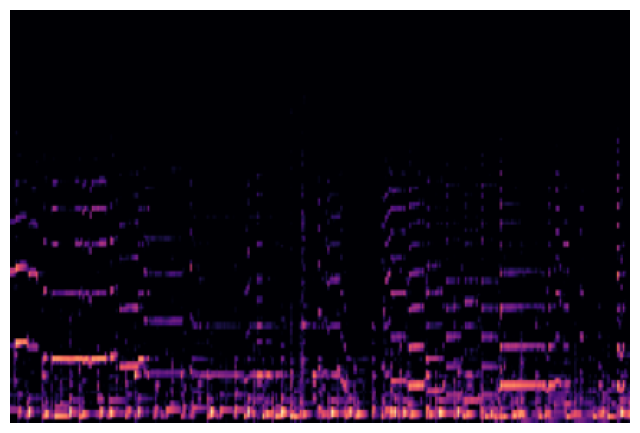

In [47]:
image_np = image.numpy()

# Plot the image
plt.figure(figsize=(8, 6))
plt.imshow(image_np)
plt.axis('off')  # Hide axes for a cleaner look
plt.show()

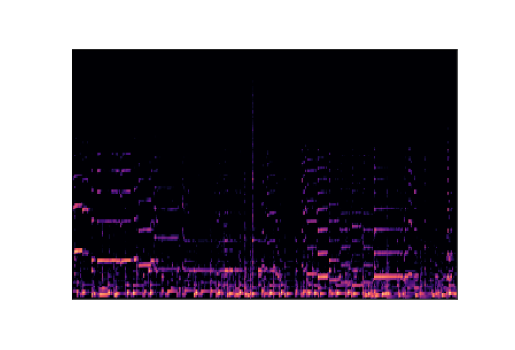

In [49]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the image
image = mpimg.imread("/kaggle/input/gtzan-dataset-music-genre-classification/Data/images_original/jazz/jazz00099.png")

# Display the image
plt.imshow(image)
plt.axis('off')
plt.show()


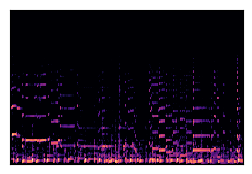

In [4]:
filePath = "../input/gtzan-dataset-music-genre-classification/Data/genres_original/jazz/jazz.00099.wav" # an example file

file, samplingRate = librosa.load(filePath)
example, _ = librosa.effects.trim(file)

hopLength = 512 # the number of samples between successive columns of the spectrogram

spectrogram = librosa.power_to_db(librosa.feature.melspectrogram(y = example, sr = samplingRate, n_fft = 2048, hop_length = hopLength, n_mels = 128, power = 4.0), ref = np.max)

plt.figure(figsize = (3, 2))
librosa.display.specshow(spectrogram, sr = samplingRate, hop_length = hopLength, x_axis = "off", y_axis = "off")
ipd.Audio(example, rate = samplingRate)

# __Preparing Data__
To fulfil the aim of this investigation, I need to predict a song's genre from a randomly chosen 30-second snippet. This means that the dependent variable (the one we are attempting to measure) is the __*song genre*__.
## Removing Erroneous Values
To ensure that the dataframe is consistent and will not cause errors in the future, I need to check for null or missing values.

In [5]:
source = "../input/gtzan-dataset-music-genre-classification/Data/images_original/" # source folder path
genres = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"] # list with the genre folder names

for genre in genres: # iterate through each genre folder
    path = os.path.join(source, genre)
    pngs = [i for i in os.listdir(path) if i[-4:] == ".png"] # get a list of .png files in the genre folder
    print(f"Size of {genre} dataset: {len(pngs)} files.")

Size of blues dataset: 100 files.
Size of classical dataset: 100 files.
Size of country dataset: 100 files.
Size of disco dataset: 100 files.
Size of hiphop dataset: 100 files.
Size of jazz dataset: 99 files.
Size of metal dataset: 100 files.
Size of pop dataset: 100 files.
Size of reggae dataset: 100 files.
Size of rock dataset: 100 files.


From the above code, it is apparent that there is a missing or corrupted file in the jazz dataset. With further inspection, it appears that the file 'jazz.00054.wav' is corrupted in the 'genres_original' directory, meaning that no spectrogram was generated for it in the 'images_original' directory.
To counter this and avoid potential bias, I will trim down all genre datasets to only 99 files in the training-validation-test splitting process.

## Splitting the Data
Dividing the available data into 3 subsets - namely **training**, **validation**, and **testing** -  is critical to the training and evaluation of a machine-learning model's performance in a robust and unbiased manner. This helps to assess the model's ability to **generalise** to unseen data, as it would in a real-world scenario.

I have chosen an **80:9:10** split for my training, validation and testing data respectively,as you can see from the dictionaries outputted below.

In [6]:
setRandom()
split = [80, 9, 10]
train, val, test = {}, {}, {} # empty dictionaries to store the filepaths
trainLen, valLen, testLen = {}, {}, {} # empty dictionaries to store the number of files under each genre for each dataset
dictionaries = [train, val, test]

for d in dictionaries:
    if d == train: num = slice(0, split[0])
    elif d == val: num = slice(split[0], split[0] + split[1])
    else: num = slice(split[0] + split[1], split[0] + split[1] + split[2])
    for genre in genres: # iterate through each genre folder
        path = os.path.join(source, genre)
        pngs = glob.glob(os.path.join(path, "*.png")) # get a list of .png filepaths in the genre folder
        selected = pngs[num] # take the first 80 files
        d[genre] = selected # store the selected files in the dictionary

lenDictionaries = [{genre: len(d[genre]) for genre in genres} for d in dictionaries]        

print(f"\033[1mTraining:\033[0m {lenDictionaries[0]}")
print(f"\033[1mValidation:\033[0m {lenDictionaries[1]}")
print(f"\033[1mTest:\033[0m {lenDictionaries[2]}")

Training: {'blues': 80, 'classical': 80, 'country': 80, 'disco': 80, 'hiphop': 80, 'jazz': 80, 'metal': 80, 'pop': 80, 'reggae': 80, 'rock': 80}
Validation: {'blues': 9, 'classical': 9, 'country': 9, 'disco': 9, 'hiphop': 9, 'jazz': 9, 'metal': 9, 'pop': 9, 'reggae': 9, 'rock': 9}
Test: {'blues': 10, 'classical': 10, 'country': 10, 'disco': 10, 'hiphop': 10, 'jazz': 10, 'metal': 10, 'pop': 10, 'reggae': 10, 'rock': 10}


## Data Formatting
The code below is necessary to allow a Tensorflow model to interpret and train with the provided data. It also optimises the data as recommended in the Kaggle 'Computer Vision' course in the prep() function.

In [7]:
batchSize = 32 # typical batch size for a neural network
genreMap = {
    "blues": 0,
    "classical": 1,
    "country": 2,
    "disco": 3,
    "hiphop": 4,
    "jazz": 5,
    "metal": 6,
    "pop": 7,
    "reggae": 8,
    "rock": 9
}
inverseGenreMap = {value: key for key, value in genreMap.items()}

def createDataset(d):
    imgSize = (288, 432) # define image and batch parameters
    imageList, labelList = [], [] # create lists to store images and labels
    
    for genre, paths in d.items():
        for path in paths:
            image = tf.cast(tf.image.resize(tf.image.decode_png(tf.io.read_file(path), channels = 3), imgSize), tf.float32) / 255.0 # normalise pixel values between 0 and 1 (preprocessing!)
            imageList.append(image)
            labelList.append(genreMap[genre]) # convert genre to its integer label

    dataset = tf.data.Dataset.from_tensor_slices((imageList, labelList)).shuffle(buffer_size=len(imageList)).batch(batchSize) # create and return tensorflow dataset
    return(dataset)

def prep(ds):
    out = (
        ds.map(lambda image, label: (tf.image.convert_image_dtype(image, tf.float32), label)) # modifies the image tensor's data type to floats
        .cache() # cache dataset elements in memory or on disk to speed up data loading
        .prefetch(buffer_size = tf.data.experimental.AUTOTUNE) # prefetch dataset elements in the background and automatically optimise data loading
    )
    return out # return the prepared and optimised dataset

training, validation, testing = prep(createDataset(train)), prep(createDataset(val)), prep(createDataset(test))
print("Datasets created.") # to let me know when it's finished running (:

Datasets created.


Below are some examples of the spectrograms in each genre for each dataset. There are some clearly noticeable patterns in the data suchas the fairly consistently loud nature of metal, but as usual there are still a few outliers most notably in blues and pop (both of which are quite wide genres).

Training Examples:


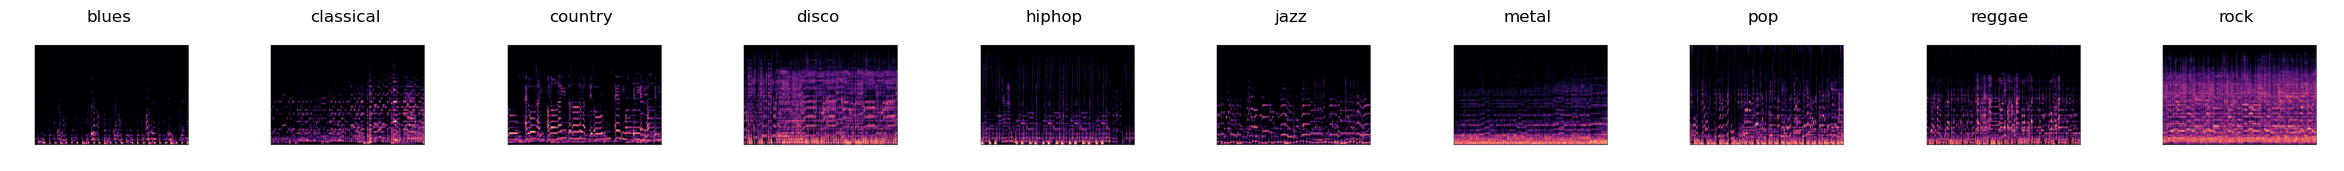

Validation Examples:


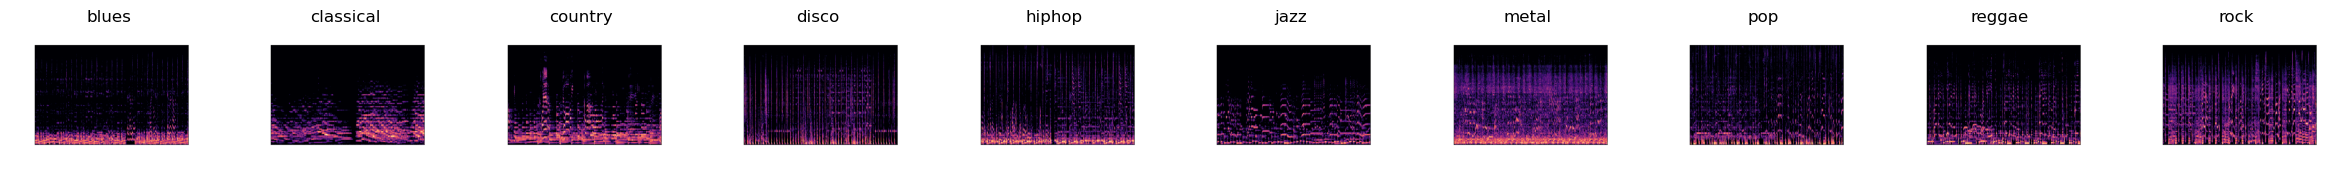

Testing Examples:


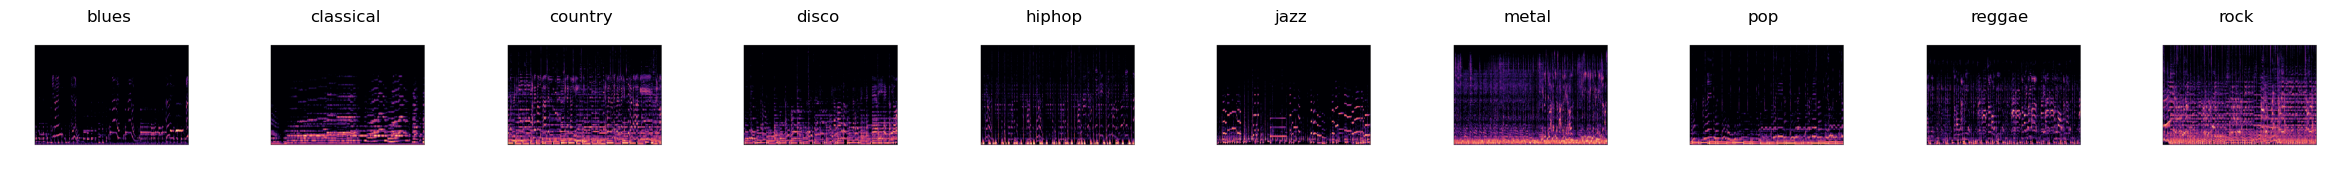

In [8]:
def view_dataset(dataset):
    genreExamples = {}  # dictionary to store examples for each label
    
    for images, labels in dataset:
        for image, label in zip(images, labels):
            label = int(label.numpy())  # convert label tensor to integer
            if label not in genreExamples:
                genreExamples[label] = image
                
        if len(genreExamples) == len(genres):
            break
    
    # display the randomly chosen examples
    plt.figure(figsize = (30, 20))
    for label, image in genreExamples.items():
        ax = plt.subplot(1, len(genres), label + 1)
        plt.imshow(image)
        plt.title(inverseGenreMap[label])
        plt.axis("off")
    plt.show()

print("\033[1mTraining Examples:\033[0m"); view_dataset(training) # shows a labelled example of a mel spectrogram from each genre from each dataset
print("\033[1mValidation Examples:\033[0m"); view_dataset(validation)
print("\033[1mTesting Examples:\033[0m"); view_dataset(testing)

## Preprocessing and Data Augmentation
Due to the nature of the data I am dealing with, it would be inappropriate to augment the images fed into the model, as all spectrograms being fed in are the same formatting and structure to beigin with. Applying transformations would be unneccessary as well as possibly disrupt training, so **it will be largely left out from this task**. However, for a model where the input data varies in structure and formatting, data augmentation is highly important.

The images' pixel values were normalised between 0 and 1 by dividing the RGB value by 255.0 as an act of preprocessing. This was essential for the models to interpret the dataset.

<a id="Choosing-and-Training-a-Model"></a>
# __Choosing and Training a Model__
Now that the data has been properly edited and formatted for machine interpretation, I need to decide upon which type of model I will use, or whether i will combine them through ensemble learning techniques.

#### **Transfer Learning Model with InceptionV3 Base (*CNN*)**
* After researching and testing with a number of pre-trained bases, the InceptionV3 architecture appeared the most promising for this application. 
* I will be using the default ImageNet weights as they have already learnt to effectively extract hierarchical features and other abstractions from images. Furthermore, ImageNet weights are typically optimised for detecting spatial patterns in images, which would be helpful for detecting patterns in frequency and volume over time.
* The weights will also be frozen to retain valuable pre-learnt features, prevent overfitting, reduce computational cost, and ensure consistency. Doing this leverages the power of pre-trained models while allowing you to fine-tune only the top layers for your specific task. 

#### **Custom Convolutional Neural Network (*CNN*)**
* By designing my own base, I'm hoping that I will be able to compete with the transfer model.

The following code is the result of hours of hyperparameter tuning and layer customisation in both models.

In [9]:
inputShape = [288, 432, 3] # the shape of the images (288px tall, 432px wide, and 3 colour channels/RGB)

earlyStopping = EarlyStopping( # a custom early stopping setup to automatically stop training when loss doesn't increase enough after a number of epochs
    min_delta = 0.001, # minimium amount of change to count as an improvement
    patience = 20, # how many epochs to wait before stopping
    restore_best_weights = True # tells it to restore back to when loss was at its lowest value
)

In [10]:
from tensorflow.keras.applications import InceptionV3 # transfer learning model
baseModel = InceptionV3(input_shape = inputShape, weights = "imagenet", include_top = False, pooling = "avg")

for layer in baseModel.layers:
    layer.trainable = False # freeze the pre-trained layers

transfer = Sequential([
    baseModel,
    
    Flatten(),
    BatchNormalization(),
    Dense(512, activation = "relu"),
    Dropout(0.3),
    Dense(256, activation = "relu"),
    Dropout(0.3), # dropout layer to prevent overfitting
    Dense(128, activation = "relu"),
    Dropout(0.3),
    Dense(len(genres), activation = "softmax")
])

transfer.compile(optimizer = tf.keras.optimizers.SGD(lr = 0.0001), loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])
transfer.summary()

87910968/87910968 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 batch_normalization_94 (Bat  (None, 2048)             8192      
 chNormalization)                                                
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               13

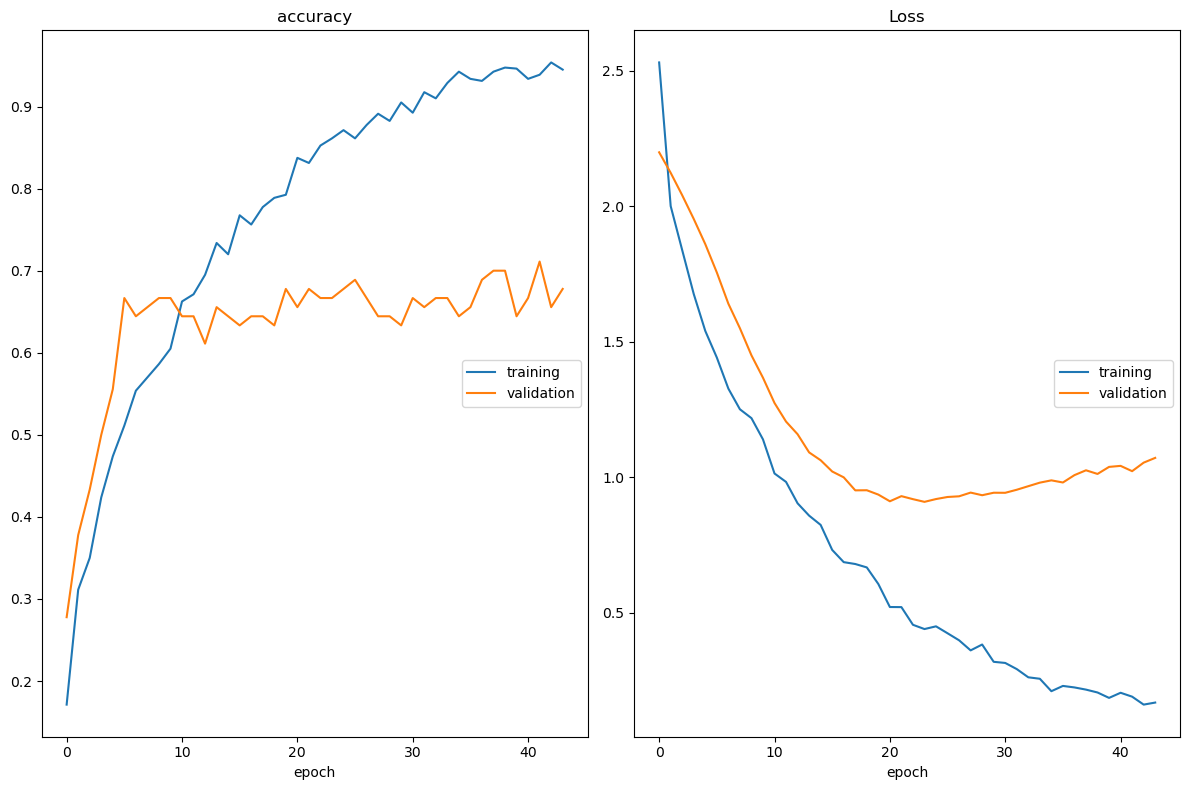

accuracy
	training         	 (min:    0.171, max:    0.954, cur:    0.945)
	validation       	 (min:    0.278, max:    0.711, cur:    0.678)
Loss
	training         	 (min:    0.162, max:    2.530, cur:    0.169)
	validation       	 (min:    0.909, max:    2.198, cur:    1.072)
25/25 [==============================] - 4s 146ms/step - loss: 0.1693 - accuracy: 0.9450 - val_loss: 1.0717 - val_accuracy: 0.6778


In [11]:
setRandom()
transferHistory = transfer.fit(training, validation_data = validation, batch_size = batchSize, epochs = 500, verbose = 1, callbacks = [earlyStopping, PlotLossesKeras()])

In [12]:
cnn = Sequential([
    BatchNormalization(input_shape = inputShape),
    
    Conv2D(32, (3, 3), activation = "relu"),
    MaxPool2D((2, 2)),
    
    Conv2D(64, (3, 3), activation = "relu"),
    MaxPool2D((2, 2)),
    
    Conv2D(128, (3, 3), activation = "relu"),
    MaxPool2D((2, 2)),
    
    Conv2D(256, (3, 3), activation = "relu"),
    MaxPool2D((2, 2)),
    
    Conv2D(512, (3, 3), activation = "relu"),
    MaxPool2D((2, 2)),
    
    Flatten(),
    Dense(1024, activation = "relu"),
    Dropout(0.5),
    Dense(512, activation = "relu"),
    Dropout(0.5),
    BatchNormalization(),
    Dense(len(genres), activation = "softmax")
])

cnn.compile(optimizer = tf.keras.optimizers.SGD(lr = 0.001), loss = "sparse_categorical_crossentropy", metrics = ["accuracy"]) # "sparse_categorical_crossentropy" because labels are integers
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_95 (Bat  (None, 288, 432, 3)      12        
 chNormalization)                                                
                                                                 
 conv2d_94 (Conv2D)          (None, 286, 430, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 143, 215, 32)     0         
 2D)                                                             
                                                                 
 conv2d_95 (Conv2D)          (None, 141, 213, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 70, 106, 64)      0         
 2D)                                                             
                                                      

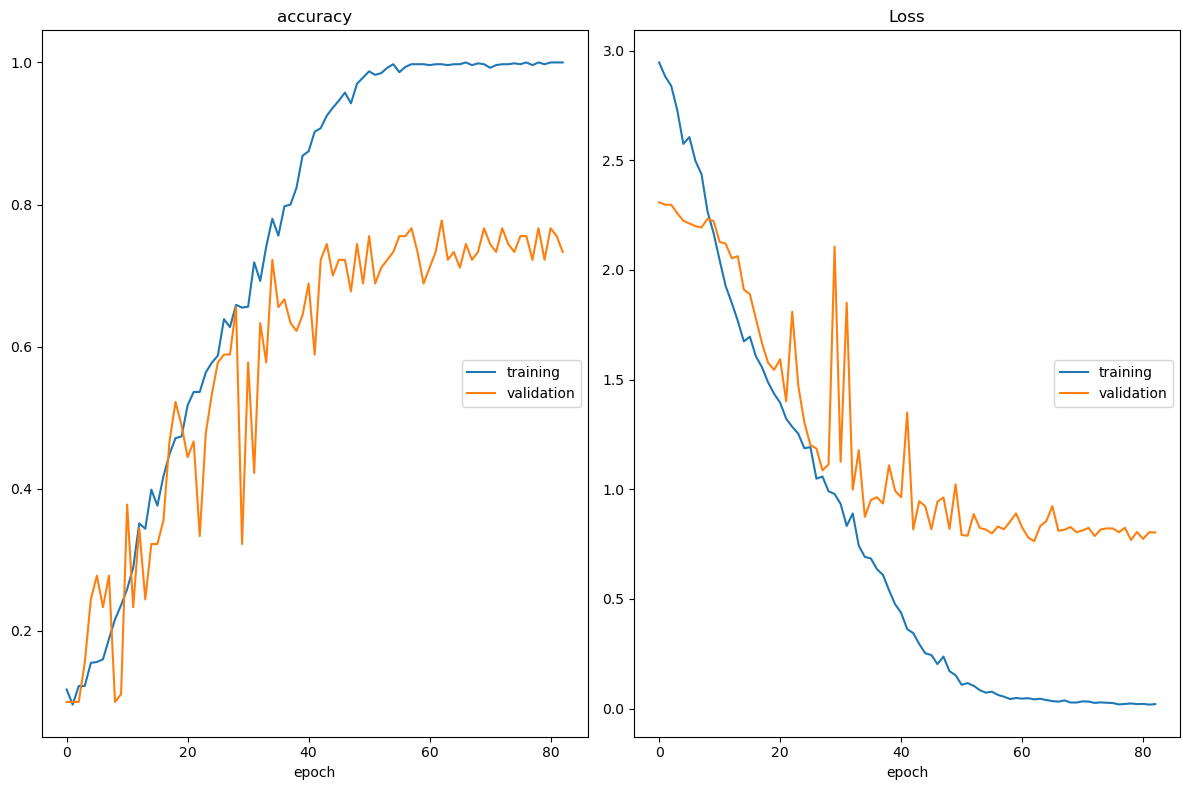

accuracy
	training         	 (min:    0.096, max:    1.000, cur:    1.000)
	validation       	 (min:    0.100, max:    0.778, cur:    0.733)
Loss
	training         	 (min:    0.018, max:    2.946, cur:    0.020)
	validation       	 (min:    0.763, max:    2.308, cur:    0.803)
25/25 [==============================] - 3s 125ms/step - loss: 0.0201 - accuracy: 1.0000 - val_loss: 0.8027 - val_accuracy: 0.7333


In [13]:
setRandom()
cnn.fit(training, validation_data = validation, batch_size = batchSize, epochs = 500, verbose = 1, callbacks = [earlyStopping, PlotLossesKeras()])

In [14]:
# Save the model
cnn.save('VGG19.keras')

In [15]:
cnn.save('VGG19_1.keras')

<a id="Hyperparameter-Tuning"></a>
# __Hyperparameter Tuning__
Throughout the course of training these models, all hyperparameters were tweaked numerous times in an attempt to find the optimal balance between generalisation ability and accuracy. I have explained my final choices below.

## Optimiser
Both models use Stochastic Gradient Descent (SGD), which is one of the most common optimisers for training deep learning models, especially with a reasonably large dataset. Its benefits include simplicity and low memory requirements. However, SGD can have slower convergence rates compared to more advanced optimisers, and typically requires careful tuning of the learning rate.
I experimented with numerous other optimisers (Adam, Adadelta, Adagrad), but they all got stuck in local minima despite being tested with numerous learning rates during training, and demonstrated worse loss and accuracy metrics than SGD.

## Epochs and Batch Size
Both models were also assigned 500 epochs and a batch size of 32. However, due to the inclusion of an early stopping program, the 500 epochs serves more as an excessive placeholder to allow for the lowest possible loss to be found before finishing training. A batch size of 32 helps with avoiding memory issues, and sped up convergence. This relatively small batch size could have introduced some of the visible noise in the training curves, though.

## Loss Function
Sparse categorical cross-entropy was employed in both models, which is appropriate when dealing with integer labels, as is the case in the dataset. It computes the cross-entropy loss between true labels and predicted labels effectively, without me having to convert the labels into tensors as would be required by standard categorical cross-entropy. Unfortunately, it can be sensitive to label noise or mislabeled data points, if there are any present in the dataset.

## Activation Function
Both models employed the rectified linear unit (ReLU) as their activation function for hidden layers, but used softmax for the output function. ReLU is one of the most common activation functions, as it introduces non-linearity and helps the network learn complex patterns. It also avoids the vanishing gradient problem (when gradients used to update the network become extremely small) and is computationally efficient. Softmax was the obvious choice for the output activation function, as it can effectively handle multiple labels.
For the hidden layers, a ReLU variant such as leaky ReLU or parametric ReLU may have been beneficial due to their immunity from the so-called 'dying ReLU problem'; this could be looked into in a future investigation.

## Learning Rate
For the transfer learning model, the learning rate was set to 10<sup>-4</sup>, while the learning rate was 10<sup>-3</sup> for my custom CNN model. A smaller learning rate can make the training more stable and allow the model to converge to a good solution, which is why a small magnitude was chosen for both. Despite this, if the learning rate is too small, training can be slow, and the model might get stuck in local minima. This process was largely trial and error.

<a id="Test-Data-Predictions"></a>
# __Test Data Predictions__
Below is the code to visually represent the accuracy of both models through confusion matrices.

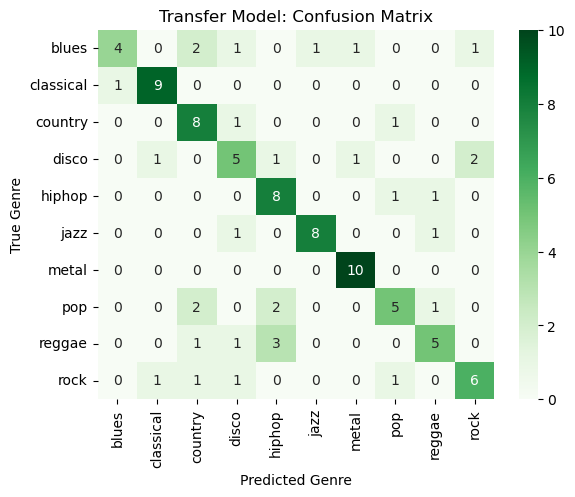

Transfer Model
Training Accuracy: 96.75% 
Train Loss: 0.1849

Validation Accuracy: 66.6667% 
Test Loss: 0.9095

Testing Accuracy: 68.0% 
Test Loss: 1.0955


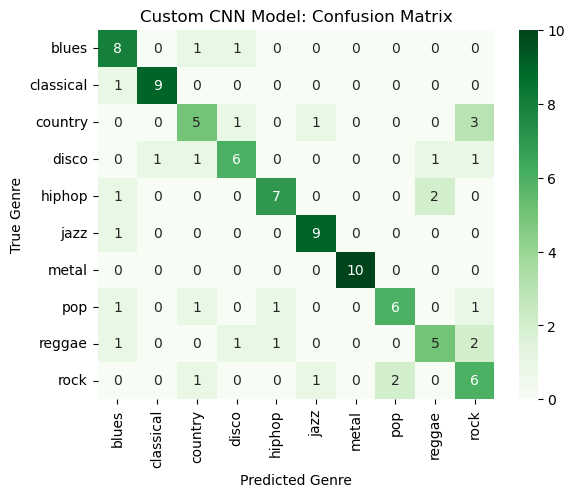

Custom CNN Model
Training Accuracy: 99.875% 
Train Loss: 0.0099

Validation Accuracy: 77.7778% 
Test Loss: 0.7632

Testing Accuracy: 71.0% 
Test Loss: 1.2101


In [16]:
def confusionMatrix(model, name):
    trueLabels = np.concatenate([y for x, y in testing], axis = 0) # get the true labels from the testing dataset

    predictedLabels = np.argmax(model.predict(testing, verbose = 0), axis = 1) # get the predicted labels from the model

    matrix = confusion_matrix(trueLabels, predictedLabels) # create the confusion matrix

    plt.figure() # plot the confusion matrix using seaborn for the heatmap
    sns.heatmap(matrix, annot = True, cmap = "Greens", xticklabels = genres, yticklabels = genres)
    plt.xlabel("Predicted Genre")
    plt.ylabel("True Genre")
    plt.title(f"{name} Model: Confusion Matrix")
    plt.show()
    
    trainStats, valStats, testStats = model.evaluate(training, verbose = 0), model.evaluate(validation, verbose = 0), model.evaluate(testing, verbose = 0)
    print(f"\033[1m{name} Model\033[0m")
    print(f"Training Accuracy: {round(trainStats[1] * 100, 4)}% \nTrain Loss: {round(trainStats[0], 4)}\n")
    print(f"Validation Accuracy: {round(valStats[1] * 100, 4)}% \nTest Loss: {round(valStats[0], 4)}\n")
    print(f"Testing Accuracy: {round(testStats[1] * 100, 4)}% \nTest Loss: {round(testStats[0], 4)}")

confusionMatrix(transfer, "Transfer")
confusionMatrix(cnn, "Custom CNN")

<a id="Evaluation"></a>
# **Prediction Evaluation**
## Transfer Learning Model
* The transfer learning model demonstrated a 97.9% training accuracy and 64.0% testing accuracy. This hints at overfitting, but the use of early stopping means that it was simply when validation loss was at its lowest point.
* As shown in its confusion matrix, it was best at predicting the genre of metal (100% accuracy), and worst at pop (30% accuracy). As noted in an example spectrogram earlier, metal clearly stood out from the rest due to the continous volume and frequencies over the 30 second snippets, so this is logical. Pop literally just stands for 'popular music', so it also checks out that the model found it difficult to identify patterns between the provided songs.

## Custom CNN Model
* The custom CNN model exhibited a 99.9% training accuracy and 73.0% testing accuracy. Yet again, this hints at overfitting, but early stopping counteracts this.
* Its confusion matrix is quite linear, with only a few patches of incorrect predictions - chiefly in the true genres of rock, hip-hop, and pop. These genres (especially pop) are quite vaguely defined at the best of times, so this is an understandable cause of a lessened accuracy. Like the transfer learning model, it predicted the genre of metal correctly 100% of the time, but instead of blues, it fell down with reggae (50% accuracy).

In general, my CNN model with a custom-made base appears to be the 'better' model through its metrics, being more generalised and able to deal with unseen data 9% more accurately and with a lower loss by 0.2809. The code below shows the CNN model being used to classfy a 'random' song below, or at least how it would be applied to a new 30-second song snippet.

In [17]:
setRandom()
genre, paths = random.choice(list(test.items())) # chooses a random genre and corresponding list of paths
path = paths[random.randint(0, len(paths) - 1)] # chooses a random path within that list
soundPath = f"{path[:-4]}.wav".replace("images_original", "genres_original") # creates a new variable for the image path's respective audio file path
soundPath = soundPath[:-9] + "." + soundPath[-9:]

image = tf.image.decode_png(tf.io.read_file(path), channels = 3)
image = tf.image.resize(image, inputShape[:2])  # resize the image to the input shape of the model
image = tf.cast(image, tf.float32) / 255.0 # normalise pixel values
image = np.expand_dims(image, axis = 0) # expand dimensions to match the batch size (even though it's just one image)

predictions = cnn.predict(image) # make a prediction using the custom cnn model
predictedGenre = inverseGenreMap[np.argmax(predictions)] # get the predicted class label

print(f"\033[1mPredicted genre:\033[0m {predictedGenre}")
print(f"\033[1mActual genre:\033[0m {genre}")
print(f"\033[1mFilepath:\033[0m {soundPath[71:]}")
ipd.Audio(soundPath)

1/1 [==============================] - 0s 235ms/step
Predicted genre: metal
Actual genre: metal
Filepath: metal/metal.00020.wav


<a id="Conclusion"></a>
# **Conclusion**

### Evaluating Hypotheses:
> **1.** *I believe that a standard Convolutional Neural Network regression model with a custom base will yield the best results given its adeptness in this data format and ability to adapt to new patterns.*

This hypothesis was largely correct, with my custom CNN model outperforming the transfer learning model with a pre-trained InceptionV3 base. This could be because the ImageNet dataset doesn't contain many (if any) spectrograms, leading my custom base to predict more accurately. Furthermore, the freezing of the weights in the transfer model's base reduces potential adaptability to the data to lose computing time and retain the pattern recognition from the pre-set ImageNet weights. Given another opportunity, I would certainly investigate the effects of unfreezing the weights.

> **2.** *Given the highly variable and subjective nature of music genres, I belive that there is only so much a small-scale neural network like mine will be able to achieve in terms of accuracy in its predictions. I am aiming for above 80% testing accuracy as an ideal result.*

Sadly, I was unable to achieve my ideal of >80% accuracy for either model, but as the hypothesis stated, there is only so much a neural network like mine will be able to achieve due to the nature of music.


Overall, I believe that this investigation has been reasonably successful in fulfilling its aim. Musical genres are quite fluid and blurry at times, so I am content with the state of both models I produced.

In [33]:
def wav_to_image(filePath, imgSize=(288, 432)):
    # Load and trim the audio file
    file, samplingRate = librosa.load(filePath)
    example, _ = librosa.effects.trim(file)

    # Create the Mel spectrogram
    hopLength = 512
    spectrogram = librosa.power_to_db(
        librosa.feature.melspectrogram(
            y=example,
            sr=samplingRate,
            n_fft=2048,
            hop_length=hopLength,
            n_mels=128,
            power=2.0
        ),
        ref=np.max
    )

    # Plot the spectrogram as an image without axes
    fig, ax = plt.subplots(figsize=(imgSize[1] / 100, imgSize[0] / 100), dpi=100)
    ax.axis('off')
    librosa.display.specshow(spectrogram, sr=samplingRate, hop_length=hopLength)
    fig.tight_layout(pad=0)

    # Save to a temporary file
    temp_img_path = 'temp_spectrogram.png'
    plt.savefig(temp_img_path, bbox_inches='tight', pad_inches=0)
    plt.close(fig)

    # Load the image and resize it to the target size
    image = tf.image.decode_png(tf.io.read_file(temp_img_path), channels=3)
    image = tf.image.resize(image, imgSize)

    # Normalize the pixel values between 0 and 1
    image = image / 255.0

    return image

file_path = '../input/gtzan-dataset-music-genre-classification/Data/genres_original/jazz/jazz.00099.wav'
spectrogram_image = wav_to_image(file_path)

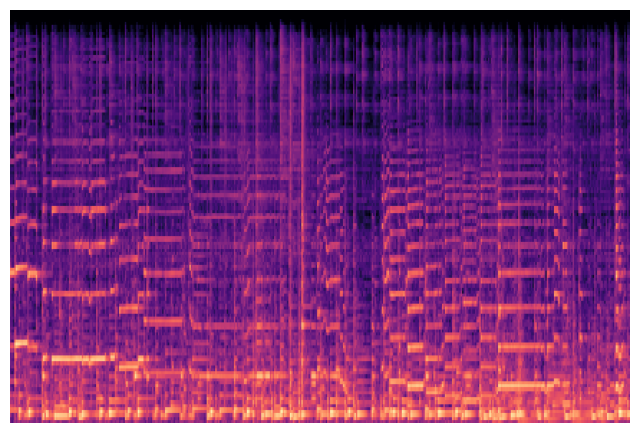

In [34]:
plt.figure(figsize=(8, 6))
plt.imshow(spectrogram_image)
plt.axis('off')  # Hide axes for a cleaner look
plt.show()